In [323]:
#Importing the necessary libraries

import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm


In [324]:
#Global Settings 
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [325]:
#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
#Linux
#os.chdir('/home/kwnabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [326]:
#Import Sentiment Data 
state = pd.read_csv(f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv")
#state = state[['date','sentiment', 'positive', 'negative', 'neutral']]
state = state[['date','sentiment']]
#state = state.groupby('date').mean().reset_index()

mins = pd.read_csv(f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv")
mins = mins[['date','sentiment', 'positive', 'negative', 'neutral']]
#mins = mins.groupby('date').mean().reset_index()

state['date'] = pd.to_datetime(state['date'])
#mins['date'] = pd.to_datetime(mins['date'])

# state = pd.merge(state, mins, on='date', how='outer')
# state['sentiment_x'] = state['sentiment_x'].fillna(state['sentiment_y'])
# state['sentiment_y'] = state['sentiment_y'].fillna(state['sentiment_x'])
# state['sentiment'] = state[['sentiment_x', 'sentiment_y']].mean(axis=1)
# print(state.head())


In [327]:
fedfunds = pd.read_csv(f'{database}/Market Data/Fed Funds/Fed Funds.csv')
fedfunds = fedfunds[['date', 'fedfunds']]
fedfunds['date'] = pd.to_datetime(fedfunds['date'])

state = pd.merge(state, fedfunds, on='date', how='outer')

state['diff'] = state['fedfunds'].diff()

state['event'] = 0

In [328]:
#Event
state['event'] = np.where((state['sentiment'].notna() == True), 1, 0)

#High Rates 
# state['event'] = np.where((state['fedfunds'] > state['fedfunds'].mean()) & (state['sentiment'].notna() == True), 1, 0)

#Rate Hike
#state['event'] = np.where((state['diff'] >= 0.25) & (state['sentiment'].notna() == True), 1, 0)

#Rate cut
#state['event'] = np.where((state['diff'] <= -0.25) & (state['sentiment'].notna() == True), 1, 0)

#Positive Sentiment 
#state = state[(state['sentiment'] > state['sentiment'].mean())]

#Negative Sentiment
#state = state[(state['sentiment'] < state['sentiment'].mean())]

state = state[['date', 'sentiment', 'event']]

In [329]:
#Create a dataframe with a column date that ranges from 1990-01-01 to 2024-01-01 with a daily frequency
#This is used to merge the dataframes
date_rng = pd.date_range(start='1/1/1990', end='1/1/2024', freq='D')
date_rng = pd.DataFrame(date_rng, columns=['date'])
date_rng['temp'] = 1
state = pd.merge(date_rng, state, on='date', how='outer')
state = state[['date', 'sentiment', 'event']]

In [330]:
#Importing Market Data
sp500 = pd.read_csv(f'{database}/Market Data/SP500/SP500.csv')
sp500 = sp500[['date', 'price', 'volume']]
sp500['volume'] = sp500['volume']/1000000
sp500 = sp500.rename(columns={'price':'sp500_price', 'volume':'sp500_volume'})

emini = pd.read_csv(f'{database}/Market Data/E Mini/E Mini SP500.csv')
emini = emini[['date', 'price']]
emini = emini.rename(columns={'price':'emini_price'})

eurodollar = pd.read_csv(f'{database}/Market Data/Eurodollar/Eurodollar.csv')
eurodollar = eurodollar[['date', 'price']]
eurodollar = eurodollar.rename(columns={'price':'eurodollar_price'})

fedfutures = pd.read_csv(f'{database}/Market Data/Fed Futures/FFF 30 Day.csv')
fedfutures = fedfutures[['date', 'price']]
fedfutures = fedfutures.rename(columns={'price':'fedfutures_price'})

vix = pd.read_csv(f'{database}/Market Data/VIX/VIX.csv')
vix = vix[['date', 'sentiment']]
vix = vix.rename(columns={'sentiment':'vix_sentiment'})

unemployment = pd.read_csv(f'{database}/Market Data/Unemployment/Unemployment.csv')
unemployment = unemployment[['date', 'unemployment']]

inflation = pd.read_csv(f'{database}/Market Data/Inflation/Inflation.csv')
inflation = inflation[['date', 'inflation']]

fedfunds = pd.read_csv(f'{database}/Market Data/Fed Funds/Fed Funds.csv')
fedfunds = fedfunds[['date', 'fedfunds']]

pce = pd.read_csv(f'{database}/Market Data/PCE/PCE.csv')
pce = pce.rename(columns={'PCEC_PCH': 'PCE', 'DATE':'date'})

gdp = pd.read_csv(f'{database}/Market Data/GDP/GDP.csv')
gdp = gdp.rename(columns={'DATE':'date', 'GDPC1':'GDP'})

gdppot = pd.read_csv(f'{database}/Market Data/GDPPOT/GDPPOT.csv')
gdppot = gdppot.rename(columns={'DATE':'date'})

In [331]:
#conveting date to datetime

sp500['date'] = pd.to_datetime(sp500['date'])
emini['date'] = pd.to_datetime(emini['date'])
eurodollar['date'] = pd.to_datetime(eurodollar['date'])
fedfutures['date'] = pd.to_datetime(fedfutures['date'])
vix['date'] = pd.to_datetime(vix['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
inflation['date'] = pd.to_datetime(inflation['date'])
fedfunds['date'] = pd.to_datetime(fedfunds['date'])
pce['date'] = pd.to_datetime(pce['date'])
gdp['date'] = pd.to_datetime(gdp['date'])
gdppot['date'] = pd.to_datetime(gdppot['date'])

In [332]:
#Print the first and last dates of every dataframe
print(f"State: {state.date.min()} - {state.date.max()}")
print(f"Mins: {mins.date.min()} - {mins.date.max()}")
print(f"SP500: {sp500.date.min()} - {sp500.date.max()}")
print(f"E Mini: {emini.date.min()} - {emini.date.max()}")
print(f"Eurodollar: {eurodollar.date.min()} - {eurodollar.date.max()}")
print(f"Fed Futures: {fedfutures.date.min()} - {fedfutures.date.max()}")
print(f"VIX: {vix.date.min()} - {vix.date.max()}")
print(f"Unemployment: {unemployment.date.min()} - {unemployment.date.max()}")
print(f"Inflation: {inflation.date.min()} - {inflation.date.max()}")
print(f"Fed Funds: {fedfunds.date.min()} - {fedfunds.date.max()}")



State: 1990-01-01 00:00:00 - 2024-02-06 00:00:00
Mins: 1998-07-02 - 2023-05-24
SP500: 1990-01-02 00:00:00 - 2024-02-01 00:00:00
E Mini: 1997-09-09 00:00:00 - 2024-02-01 00:00:00
Eurodollar: 1990-02-02 00:00:00 - 2023-06-15 00:00:00
Fed Futures: 1990-12-14 00:00:00 - 2024-02-01 00:00:00
VIX: 1990-02-02 00:00:00 - 2024-02-01 00:00:00
Unemployment: 1990-01-01 00:00:00 - 2024-01-01 00:00:00
Inflation: 1990-01-01 00:00:00 - 2023-12-01 00:00:00
Fed Funds: 1990-01-01 00:00:00 - 2024-02-06 00:00:00


In [333]:

#pce['PCE'] = np.log(pce['PCE'])

gdp['GDP'] = np.log(gdp['GDP'])

gdppot['GDPPOT'] = np.log(gdppot['GDPPOT'])

In [334]:
cycle, trend = sm.tsa.filters.hpfilter(pce['PCE'], 1600)

pce_decomp = pce[['PCE']]
pce_decomp["cycle"] = cycle
pce_decomp["trend"] = trend

# print(pce_decomp.head())

# fig, ax = plt.subplots(figsize=(20, 20))
# #pce_decomp[["PCE", "trend"]].plot(ax=ax, fontsize=16)
# pce_decomp[["cycle"]].plot(ax=ax, fontsize=16)
# plt.show()

pce = pd.merge(pce, pce_decomp, on='PCE', how='outer')
pce = pce[['date', 'PCE', 'cycle', 'trend']]
pce = pce.rename(columns={'cycle':'pce_cycle', 'trend':'pce_trend'})

In [335]:
cycle, trend = sm.tsa.filters.hpfilter(gdp['GDP'], 1600)

gdp_decomp = gdp[['GDP']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

gdp = pd.merge(gdp, gdp_decomp, on='GDP', how='outer')
gdp = gdp[['date', 'GDP', 'cycle', 'trend']]
gdp = gdp.rename(columns={'cycle':'gdp_cycle', 'trend':'gdp_trend'})

In [336]:
cycle, trend = sm.tsa.filters.hpfilter(gdppot['GDPPOT'], 1600)

gdppot_decomp = gdppot[['GDPPOT']]
gdppot_decomp["cycle"] = cycle
gdppot_decomp["trend"] = trend

gdppot = pd.merge(gdppot, gdppot_decomp, on='GDPPOT', how='outer')
gdppot = gdppot[['date', 'GDPPOT', 'cycle', 'trend']]
gdppot = gdppot.rename(columns={'cycle':'gdppot_cycle', 'trend':'gdppot_trend'})

In [337]:
gdp = pd.merge(gdp, gdppot, on='date', how='outer') 

gdp['gap'] = gdp['gdp_trend'] - gdp['gdppot_trend']

In [338]:

state_q = state.copy(deep=True)
state_q = state_q[['date', 'sentiment']]
state_q = pd.merge(state_q, pce, on='date', how='outer')
state_q = pd.merge(state_q, gdp, on='date', how='outer')

market = date_rng.copy(deep=True)
market = market[['date']]
market = pd.merge(market, sp500, on='date', how='outer')
market = pd.merge(market, emini, on='date', how='outer')
market = pd.merge(market, eurodollar, on='date', how='outer')
market = pd.merge(market, fedfutures, on='date', how='outer')
market = pd.merge(market, vix, on='date', how='outer')
market = pd.merge(market, unemployment, on='date', how='outer')
market = pd.merge(market, inflation, on='date', how='outer')
market = pd.merge(market, fedfunds, on='date', how='outer')

market = market.sort_values(by='date')

market['unemployment'] = market['unemployment'].fillna(method='ffill')
market['inflation'] = market['inflation'].fillna(method='ffill')

market = market.fillna(method='ffill')

state_q = pd.merge(state_q, market, on='date', how='outer')

In [339]:


taylor = pd.read_csv(f'/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv')
taylor['date'] = pd.to_datetime(taylor['date'])
state_q = pd.merge(state_q, taylor, on='date', how='outer')
state_q = state_q.rename(columns={'Taylor':'taylor'})

state_q = state_q.set_index('date')
state_q = state_q.resample('Q').mean().reset_index()

for i in range(1, 11):
    state_q[f'sentiment_{i}'] = state_q['sentiment'].shift(i)
    state_q[f'sentiment_forward{i}'] = state_q['sentiment'].shift(-i)
print(state_q.head())

        date  sentiment  PCE  pce_cycle  pce_trend  GDP  gdp_cycle  gdp_trend  \
0 1954-09-30        NaN  NaN        NaN        NaN  NaN        NaN        NaN   
1 1954-12-31        NaN  NaN        NaN        NaN  NaN        NaN        NaN   
2 1955-03-31        NaN  NaN        NaN        NaN  NaN        NaN        NaN   
3 1955-06-30        NaN  NaN        NaN        NaN  NaN        NaN        NaN   
4 1955-09-30        NaN  NaN        NaN        NaN  NaN        NaN        NaN   

   GDPPOT  gdppot_cycle  ...  sentiment_1  sentiment_2  sentiment_3  \
0     NaN           NaN  ...          NaN          NaN          NaN   
1     NaN           NaN  ...          NaN          NaN          NaN   
2     NaN           NaN  ...          NaN          NaN          NaN   
3     NaN           NaN  ...          NaN          NaN          NaN   
4     NaN           NaN  ...          NaN          NaN          NaN   

   sentiment_4  sentiment_5  sentiment_6  sentiment_7  sentiment_8  \
0          NaN  

In [340]:
#Calculate taylor rule
#state_q['taylor'] = 2 + state_q['pce_trend'] + 0.5*(state_q['pce_trend'] - 2) + 0.5*(state_q['gap'])




state_q = state_q[(state_q['date'] >= '2000-01-01') & (state_q['date'] <= '2023-06-30')]
print(state_q.head())

state_q.to_csv(f'/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv', index=False)


          date  sentiment    PCE  pce_cycle  pce_trend    GDP  gdp_cycle  \
182 2000-03-31     0.2143 2.3377     0.8598     1.4779 9.5381     0.0137   
183 2000-06-30     0.2500 1.4157    -0.0471     1.4628 9.5561     0.0236   
184 2000-09-30     0.2000 1.6102     0.1640     1.4462 9.5571     0.0168   
185 2000-12-31     0.4118 1.4461     0.0170     1.4291 9.5631     0.0152   
186 2001-03-31    -0.2692 1.1085    -0.3042     1.4127 9.5598     0.0045   

     gdp_trend  GDPPOT  gdppot_cycle  ...  sentiment_1  sentiment_2  \
182     9.5244  9.5220        0.0051  ...       0.2500       0.2000   
183     9.5325  9.5326        0.0063  ...       0.2000       0.4118   
184     9.5403  9.5426        0.0071  ...       0.4118      -0.2692   
185     9.5479  9.5519        0.0075  ...      -0.2692      -0.2000   
186     9.5553  9.5606        0.0074  ...      -0.2000      -0.1765   

     sentiment_3  sentiment_4  sentiment_5  sentiment_6  sentiment_7  \
182       0.4118      -0.2692      -0.2000  

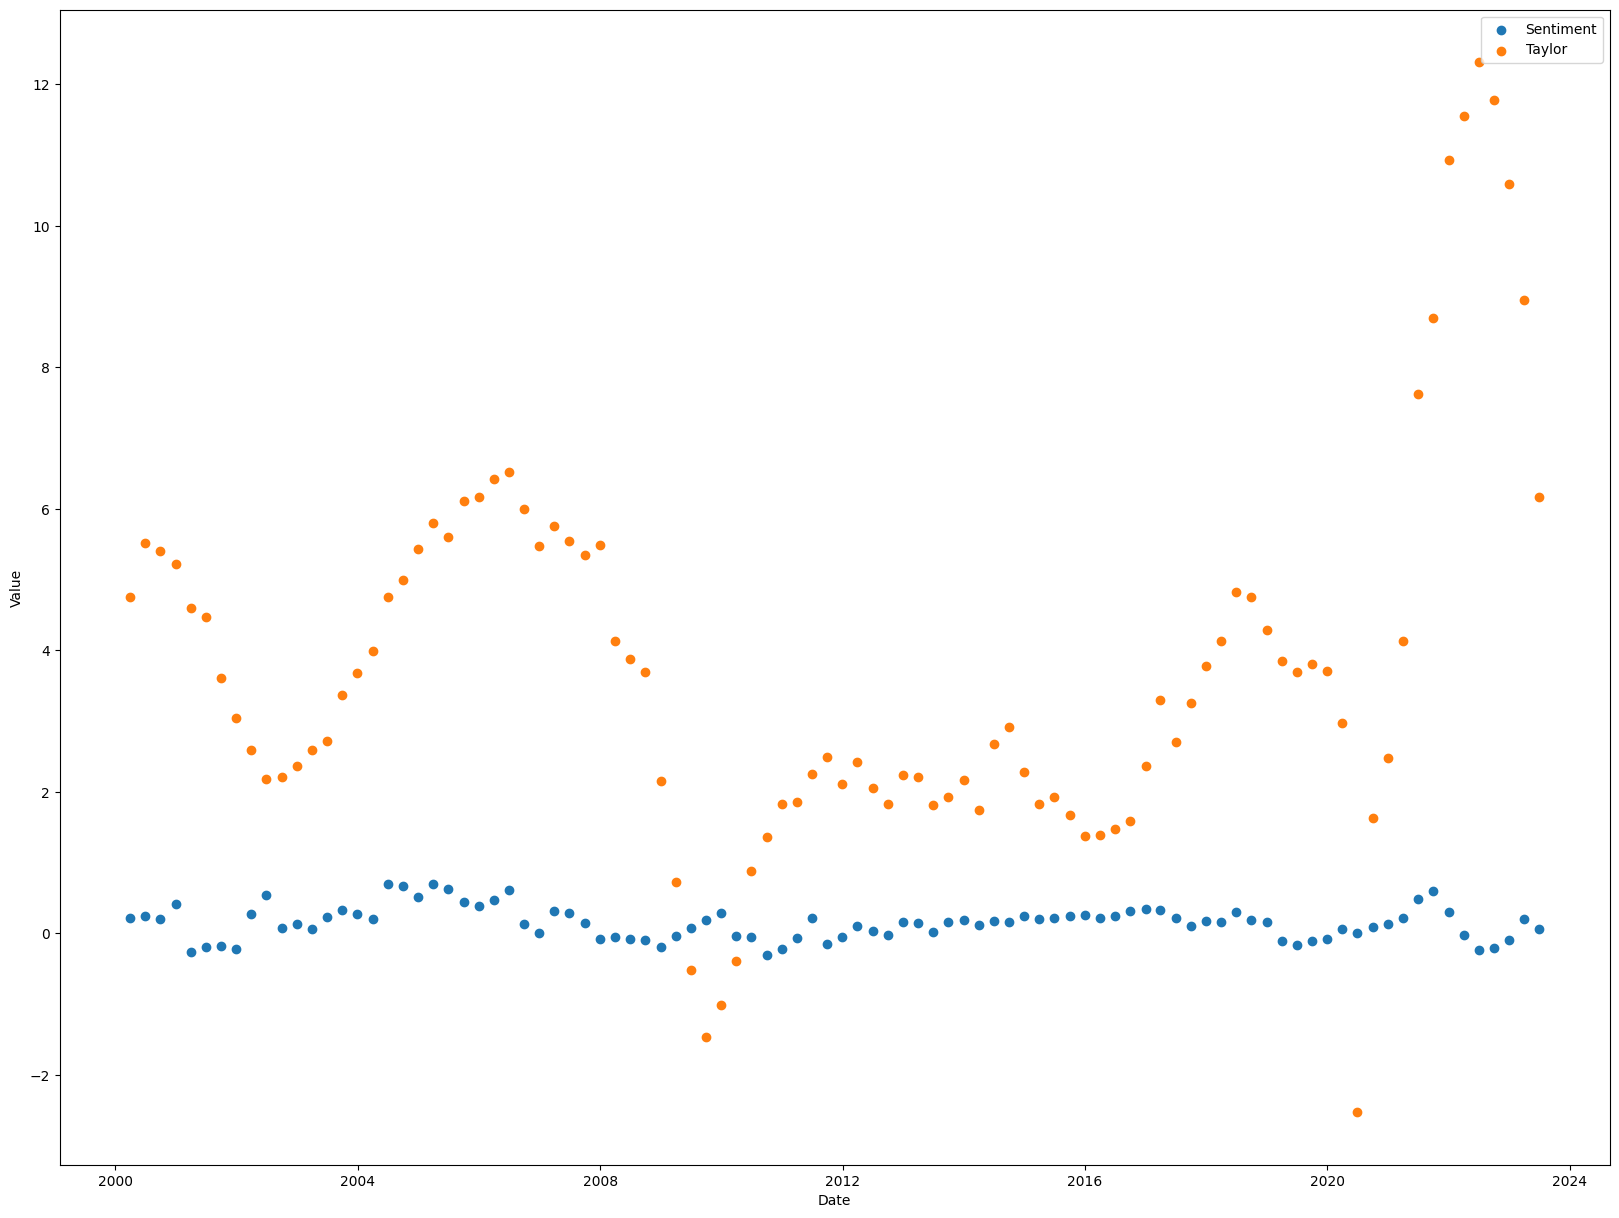

In [341]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))  # Adjust the figsize as per your preference

ax.scatter(state_q['date'], state_q['sentiment'], label='Sentiment')
ax.scatter(state_q['date'], state_q['taylor'], label='Taylor')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.show()


In [342]:
stop()
state = pd.merge(state, fedfunds, on='date', how='outer')

NameError: name 'stop' is not defined

In [ ]:
market = date_rng.copy(deep=True)
market = market[['date']]
market = pd.merge(market, sp500, on='date', how='outer')
market = pd.merge(market, emini, on='date', how='outer')
market = pd.merge(market, eurodollar, on='date', how='outer')
market = pd.merge(market, fedfutures, on='date', how='outer')
market = pd.merge(market, vix, on='date', how='outer')
market = pd.merge(market, unemployment, on='date', how='outer')
market = pd.merge(market, inflation, on='date', how='outer')
market = pd.merge(market, fedfunds, on='date', how='outer')

market = market.sort_values(by='date')

market['unemployment'] = market['unemployment'].fillna(method='ffill')
market['inflation'] = market['inflation'].fillna(method='ffill')

market = market.fillna(method='ffill')

state = pd.merge(state, market, on='date', how='outer')

state = state[state['date'] >= '2001-01-01']



In [ ]:
#Replace NaN with 0
state['event'] = state['event'].fillna(0)
#Sort state by date assending
state = state.sort_values(by='date')

In [ ]:
#create correlation matrix
#print(state.corr())

In [ ]:
#print(state.describe())

In [ ]:
#Create a column that is the number of days since the last event for up to 10 days after the event
state['days_since_event'] = state['event'].groupby((state['event'] != state['event'].shift()).cumsum()).cumcount()
state['days_since_event'] = state['days_since_event'] + 1
#If state state['days_since_event'] is greater than 10, set it to nan
state['days_since_event'] = np.where(state['days_since_event'] > 30, np.nan, state['days_since_event'])
#If event = 1 sent days_since_event to 0
state['days_since_event'] = np.where(state['event'] == 1, 0, state['days_since_event'])

#Now do the same thing but for 10 days leading up to the event 
state['days_until_event'] = state['event'][::-1].groupby((state['event'][::-1] != state['event'][::-1].shift()).cumsum()).cumcount()[::-1]
state['days_until_event'] = state['days_until_event'] + 1
#If state state['days_until_event'] is greater than 10, set it to nan
state['days_until_event'] = np.where(state['days_until_event'] > 10, np.nan, state['days_until_event'])
#If event = 1 sent days_until_event to 0
state['days_until_event'] = np.where(state['event'] == 1, 0, state['days_until_event'])
state['days_until_event'] = state['days_until_event'] * -1

#create column event_count that is the combonation of days_since_event and days_until_event where it is na if both are na
state['event_count'] = state['days_since_event'].fillna(state['days_until_event'])



In [ ]:
state = state[['date', 'sp500_price', 'sp500_volume', 'emini_price', 'eurodollar_price', 'fedfutures_price', 'vix_sentiment', 'event_count', 'unemployment', 'inflation', 'fedfunds']]
state = state.dropna()

state = state.groupby('event_count').mean().reset_index()

#create a graph of the mean of the market varaibles over the 10 days leading up to and after the event with all the variables scaled between -1 and 1
state['sp500_price'] = (state['sp500_price'] - state['sp500_price'].mean()) / (state['sp500_price'].max() - state['sp500_price'].min())
#state['sp500_std_30'] = (state['sp500_std_30'] - state['sp500_std_30'].mean()) / (state['sp500_std_30'].max() - state['sp500_std_30'].min())
#state['sp500_std_mean'] = (state['sp500_std_mean'] - state['sp500_std_mean'].mean()) / (state['sp500_std_mean'].max() - state['sp500_std_mean'].min())
state['sp500_volume'] = (state['sp500_volume'] - state['sp500_volume'].mean()) / (state['sp500_volume'].max() - state['sp500_volume'].min())
state['emini_price'] = (state['emini_price'] - state['emini_price'].mean()) / (state['emini_price'].max() - state['emini_price'].min())
state['eurodollar_price'] = (state['eurodollar_price'] - state['eurodollar_price'].mean()) / (state['eurodollar_price'].max() - state['eurodollar_price'].min())
state['fedfutures_price'] = (state['fedfutures_price'] - state['fedfutures_price'].mean()) / (state['fedfutures_price'].max() - state['fedfutures_price'].min())
state['vix_sentiment'] = (state['vix_sentiment'] - state['vix_sentiment'].mean()) / (state['vix_sentiment'].max() - state['vix_sentiment'].min())
state['unemployment'] = (state['unemployment'] - state['unemployment'].mean()) / (state['unemployment'].max() - state['unemployment'].min())
state['inflation'] = (state['inflation'] - state['inflation'].mean()) / (state['inflation'].max() - state['inflation'].min())
state['fedfunds'] = (state['fedfunds'] - state['fedfunds'].mean()) / (state['fedfunds'].max() - state['fedfunds'].min())



#Plot the data
fig, ax = plt.subplots(figsize=(25, 15))
ax.plot(state['event_count'], state['sp500_price'], label='SP500 Price')
ax.plot(state['event_count'], state['sp500_volume'], label='SP500 Volume')
ax.plot(state['event_count'], state['emini_price'], label='E Mini Price')
ax.plot(state['event_count'], state['eurodollar_price'], label='Eurodollar Price')
ax.plot(state['event_count'], state['fedfutures_price'], label='Fed Futures Price')
ax.plot(state['event_count'], state['vix_sentiment'], label='VIX Sentiment')
#ax.plot(state['event_count'], state['unemployment'], label='Unemployment')
#ax.plot(state['event_count'], state['inflation'], label='Inflation')
#ax.plot(state['event_count'], state['fedfunds'], label='Fed Funds')
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))

ax.set_xticks(state['event_count'])

#Set Y axis sale to -1 to 1
ax.set_ylim(-1, 1)

# #Add a vertical line at all days +-10 Days from the event
# for i in range(0, 11):
#     ax.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
#     ax.axvline(x=i * -1, color='gray', linestyle='--', alpha=0.5)

#Add a vertical line at all days 25 Days from the event
for i in range(0, 31):
    ax.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
for i in range(0, 11):
    ax.axvline(x=i * -1, color='gray', linestyle='--', alpha=0.5)
    
    
#Create a Black Vertical line at 21 days from the event
ax.axvline(x=21, color='black', linestyle='-', alpha=0.5)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

ax.legend()
plt.show()

